In [1]:
import os

In [2]:
os.environ['OMP_NUM_THREADS']='1'

In [3]:
import gym, ray

from time import sleep
from pong import keep_ids

In [4]:
import torch
import torch.nn.functional as F

from torch import nn, optim

In [5]:
ray.init(object_store_memory=int(0.5*2**30), redis_max_memory=int(0.5*2**30))

2019-02-21 17:34:04,870	INFO node.py:278 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-02-21_17-34-04_13587/logs.
2019-02-21 17:34:04,976	INFO services.py:396 -- Waiting for redis server at 127.0.0.1:36200 to respond...
2019-02-21 17:34:05,097	INFO services.py:396 -- Waiting for redis server at 127.0.0.1:20500 to respond...
2019-02-21 17:34:05,104	INFO services.py:798 -- Starting Redis shard with 0.54 GB max memory.
2019-02-21 17:34:05,141	INFO services.py:1360 -- Starting the Plasma object store with 0.5368709119999999 GB memory using /dev/shm.



View the web UI at http://localhost:8889/notebooks/ray_ui.ipynb?token=49fa4d8e94a033bc5eefc92becf35f60d17dd15208e09cab



{'node_ip_address': None,
 'redis_address': '192.168.1.21:36200',
 'object_store_address': '/tmp/ray/session_2019-02-21_17-34-04_13587/sockets/plasma_store',
 'webui_url': 'http://localhost:8889/notebooks/ray_ui.ipynb?token=49fa4d8e94a033bc5eefc92becf35f60d17dd15208e09cab',
 'raylet_socket_name': '/tmp/ray/session_2019-02-21_17-34-04_13587/sockets/raylet'}

In [6]:
device = torch.device('cuda')

In [7]:
env = gym.make('Breakout-ramDeterministic-v4')

In [8]:
n = env.observation_space.shape[0]
a = 4 #env.action_space.n

In [9]:
rom_action = lambda a: a

Hyperparameters

In [10]:
n_steps = 10 ** 6
n_steps_test = 100
lr_actor = 1e-3
lr_critic = 1e-3
gamma = 0.99
tau = 20
n_workers = 16
chi = 1e-3
epsilon = 0.2
epochs = 4

In [11]:
normalize = lambda x: (x / 127.5 - 1).astype(np.float32)

In [12]:
entropy = lambda x: (-(F.log_softmax(x, dim=-1) * F.softmax(x, dim=-1)).sum(-1)).mean()

In [13]:
r_norm = lambda r: np.float32(r / 1)

In [14]:
def param_cast(params, device):
    for k, v in params.items():
        if isinstance(v, torch.Tensor):
            params[k] = v.to(device)
            
    return params

## Create Model

In [15]:
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(n, 50, batch_first=True)
        self.fc = nn.Linear(50, a)
        self.device = torch.device('cpu')
        self.reset()
        
    def forward(self, x):
        x, self.h = self.rnn(x, self.h)
        return self.fc(x)
        
    def reset(self):
        self.h = None
        
    def to(self, *args, **kwargs):
        super().to(*args, **kwargs)
        self.device = self.fc.weight.data.device
        return self
    
    def detach(self):
        if self.h is not None:
            self.h = (self.h[0].detach(), self.h[1].detach())
    
    @torch.no_grad()
    def act(self, observation, probabilistic=True, return_prob=False):
        if not torch.is_tensor(observation):
            observation = torch.tensor(observation, device=self.device).view(1, 1, -1)
            
        scores = self(observation).view(-1)
        if probabilistic: 
            probs = F.softmax(scores, dim=-1)
            action = torch.multinomial(probs, 1)[0]
            p = probs[action]
        else:
            p, action = scores.max(dim=-1)
        
        return (action.long(), p) if return_prob else action.long()
        
actor = Actor().to(device)

In [16]:
class Critic(nn.Sequential):
    def __init__(self):
        super().__init__(nn.Linear(n, 50), nn.SELU(), nn.Linear(50, 1))
        
critic = Critic().to(device)

In [17]:
optimizer_actor = optim.RMSprop(actor.parameters(), lr_actor)
optimizer_critic = optim.RMSprop(critic.parameters(), lr_critic)

In [18]:
@ray.remote
class Worker:
    def __init__(self, parameters):
        self.env = gym.make('Pong-ramDeterministic-v4')
        self.actor = Actor()
        self.actor.load_state_dict(parameters)
        self.done = True
        self.steps = 0
        
    def run(self, parameters):
        self.actor.load_state_dict(parameters)
        
        states, actions, probs, rewards = [], [], [], []
        to_reset = False
        
        if not self.done: states.append(self.state)
        while len(actions) < tau:
            if self.done:
                self.steps = 0
                to_reset = True
                self.actor.reset()
                self.state = normalize(env.reset())
                states.clear(); actions.clear(); probs.clear(); rewards.clear()
                states.append(self.state)
                
            action, prob = self.actor.act(self.state, return_prob=True)
            action = action.item(); prob = prob.item()
            self.state, reward, self.done, _ = env.step(rom_action(action))
            self.state = normalize(self.state)
            states.append(self.state); actions.append(action); probs.append(np.float32(prob))
            rewards.append(r_norm(reward))
            
        done = np.array(self.done, dtype=np.float32)
        to_reset = np.array(to_reset, dtype=np.float32)
        return np.stack(states), np.stack(actions), np.stack(probs), np.stack(rewards), done, to_reset

## Train

In [19]:
total_rewards = []
actor_losses = []
critic_losses = []
entropy_losses = []

In [20]:
def get_advantages(states, actions, rewards, dones):
    advantages = torch.zeros_like(rewards)
    
    optimizer_critic.zero_grad()
    
    # Remember to detach
    R = critic(states[:, -1]).squeeze(1).detach() * (1 - dones) # Returns
    
    for i in range(tau)[::-1]:
        R = rewards[:, i] + gamma * R
        advantages[:, i] = R - critic(states[:, i]).squeeze(1)
        
    return advantages

In [21]:
def train_actor_epoch(states, actions, probs, advantages, to_reset):
    if actor.h is not None:
        actor.h[0][0] *= (1 - to_reset.unsqueeze(-1))
        actor.h[1][0] *= (1 - to_reset.unsqueeze(-1))
    
    actor.detach()
    h = actor.h
    losses_actor, losses_entropy = 0, 0
    for _ in range(epochs):
        actor.h = h
        actor.detach()
        loss_actor, loss_entropy = train_actor_step(states[:, :-1], actions, probs, advantages)
        
        losses_actor += loss_actor; losses_entropy += loss_entropy
        
    return losses_actor / epochs, losses_entropy / epochs

In [22]:
def train_actor_step(states, actions, probs, advantages):
    optimizer_actor.zero_grad()
    
    action_scores = actor(states)
    current_probs = F.softmax(action_scores, dim=-1)
    current_probs = current_probs.gather(-1, actions.unsqueeze(-1)).squeeze(-1)
    r = current_probs / probs

    # Remember to detach the advantages
    # We don't want the loss to affect the critic
    r = -torch.min(r * advantages.detach(),
                   r.clamp(1 - epsilon, 1 + epsilon) * advantages.detach())

    loss_actor = r.mean()

    loss_entropy = entropy(action_scores)
    loss = loss_actor - chi * loss_entropy
    loss.backward(retain_graph=True)
    optimizer_actor.step()
        
    return loss_actor.item(), loss_entropy.item()

In [23]:
def train_critic_step(advantages):
    # Remember to detach the advantages
    # We don't want the loss to affect the critic
    loss_critic = F.mse_loss(advantages, torch.zeros_like(advantages))
    loss_critic.backward()
    optimizer_critic.step()
    
    return loss_critic.item()

In [24]:
def test_one_episode(n_steps, probabilistic=True):
    l_actor = Actor().to(device)
    l_actor.load_state_dict(actor.state_dict())
    state = normalize(env.reset())
    done = False
    total_rewards = 0
    
    for step in range(n_steps):
        action = l_actor.act(state, probabilistic).item()
        next_state, reward, done, _ = env.step(rom_action(action))
        
        total_rewards += reward
        state = normalize(next_state)
        if done: break
            
    return total_rewards

In [25]:
 """
actor.load_state_dict(torch.load(DIR_NB / 'checkpoints' / 'actor.pt'))
critic.load_state_dict(torch.load( DIR_NB / 'checkpoints' / 'critic.pt'))
optimizer_actor.load_state_dict(torch.load(DIR_NB / 'checkpoints' / 'actor-opt.pt'))
optimizer_critic.load_state_dict(torch.load( DIR_NB / 'checkpoints' / 'critic-opt.pt'))
 """

"\nactor.load_state_dict(torch.load(DIR_NB / 'checkpoints' / 'actor.pt'))\ncritic.load_state_dict(torch.load( DIR_NB / 'checkpoints' / 'critic.pt'))\noptimizer_actor.load_state_dict(torch.load(DIR_NB / 'checkpoints' / 'actor-opt.pt'))\noptimizer_critic.load_state_dict(torch.load( DIR_NB / 'checkpoints' / 'critic-opt.pt'))\n"

In [26]:
old_params = param_cast(actor.state_dict(), 'cpu')

In [27]:
workers = [Worker.remote(old_params) for _ in range(n_workers)]

In [40]:
pbar = tqdm(range(n_steps // (tau * n_workers)))
for step in pbar:   
    results = ray.get([worker.run.remote(old_params) for worker in workers])
    old_params = ray.put(param_cast(actor.state_dict(), 'cpu'))
    
    (states, actions, probs,
    rewards, dones, to_reset) = [torch.tensor(np.stack(x), device=device)
                                for x in zip(*results)]

    advantages = get_advantages(states, actions, rewards, dones)

    loss_actor, loss_entropy = train_actor_epoch(states, actions, probs, advantages, to_reset)
    #loss_actor, loss_entropy = train_actor_step(states[:, :-1], actions, probs, advantages, to_reset)
    loss_critic = train_critic_step(advantages)

    if not step % 100:
        actor_losses.append(loss_actor)
        entropy_losses.append(loss_entropy)
        critic_losses.append(loss_critic)
        total_rewards.append(test_one_episode(n_steps_test))
        pbar.set_description(f'{total_rewards[-1]:.2f}')

In [29]:
torch.save(actor.state_dict(), DIR_NB / 'checkpoints' / 'actor.pt')
torch.save(critic.state_dict(), DIR_NB / 'checkpoints' / 'critic.pt')
torch.save(optimizer_actor.state_dict(), DIR_NB / 'checkpoints' / 'actor-opt.pt')
torch.save(optimizer_critic.state_dict(), DIR_NB / 'checkpoints' / 'critic-opt.pt')

In [30]:
groupmean = lambda x, n=1: [sum(x[i:i + n]) / n for i in range(0, len(x) - n, n)]

In [31]:
jtplot_style()

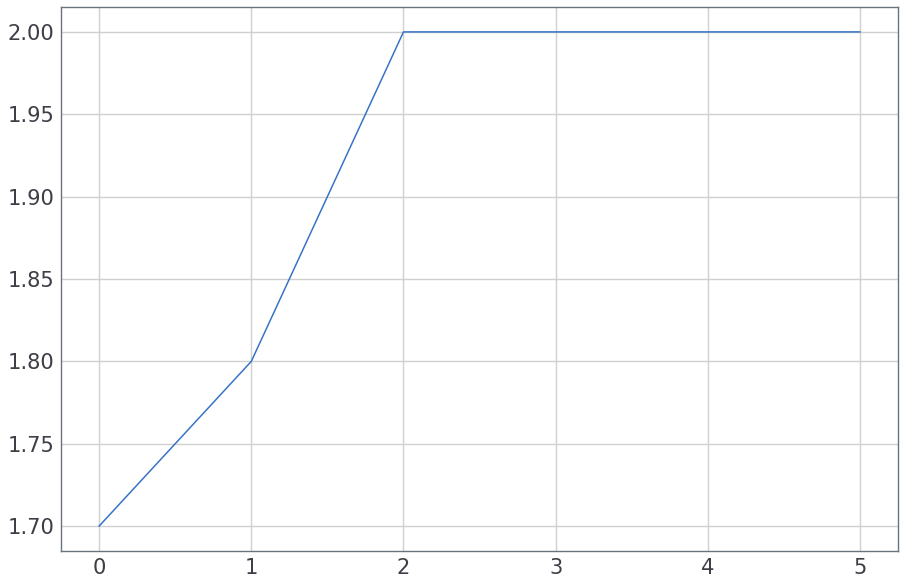

In [41]:
plot(groupmean(total_rewards, 10))

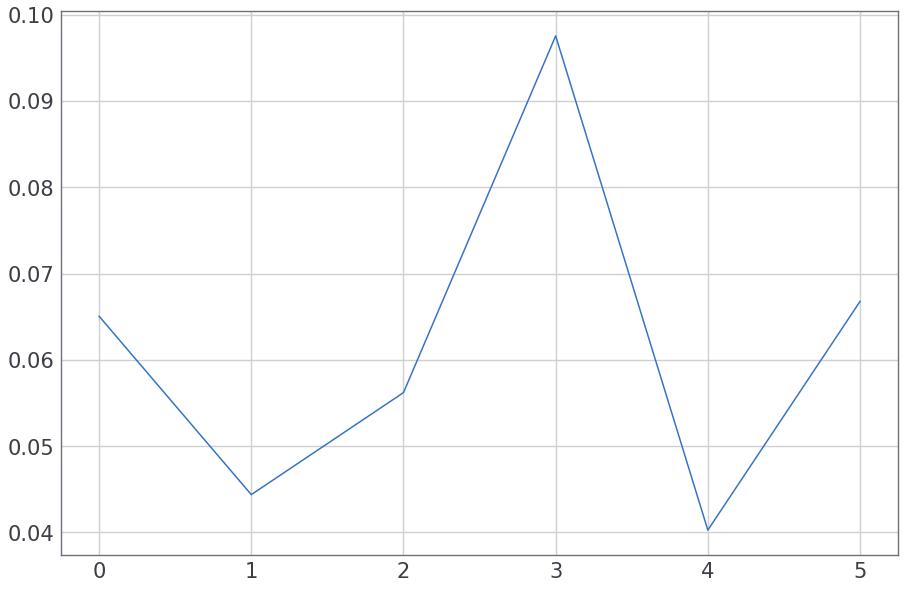

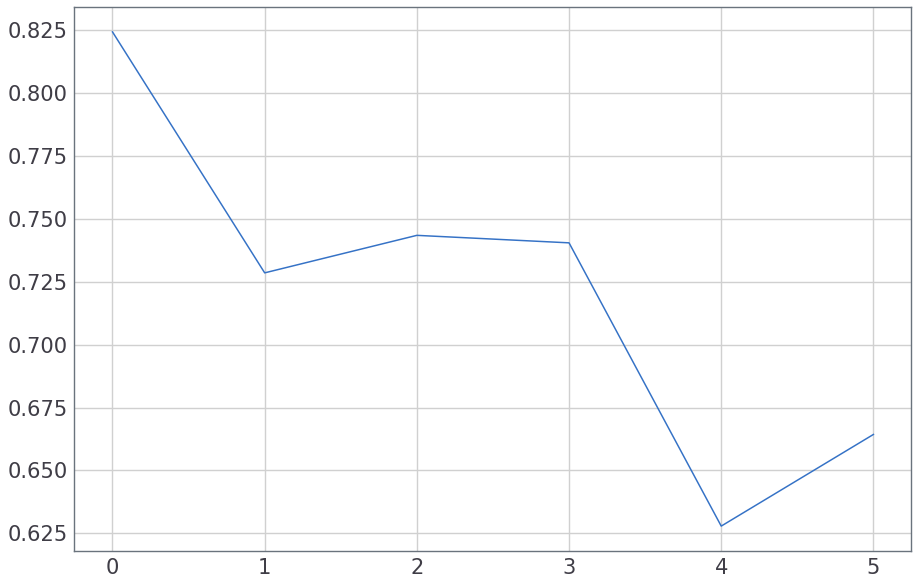

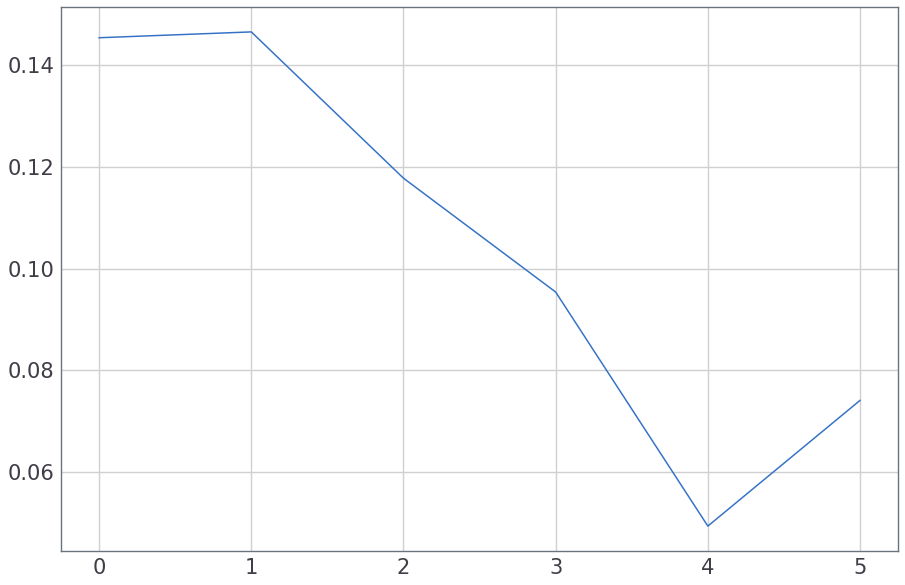

In [42]:
plot(groupmean(np.abs(actor_losses), 10)); plt.show()
plot(groupmean(np.abs(entropy_losses), 10)); plt.show()
plot(groupmean(critic_losses, 10)); plt.show()

In [43]:
test_one_episode(10000, probabilistic=False)

11.0

In [44]:
test_one_episode(10000, probabilistic=True)

11.0

In [47]:
for episode in range(1):
    actor.reset()
    state = normalize(env.reset())
    done = False
    r = 0

    for step in range(10000):
        env.render()
        action = actor.act(state, probabilistic=True).item()
        #with torch.no_grad():
            #a_ = actor(torch.tensor(state, device=device).view(1, 1, -1)).cpu().numpy()
            #print('Actor', a_)
            #print('Critic', critic(torch.tensor(state, device=device)).squeeze().item())
        state, reward, done, _ = env.step(rom_action(action))
        state = normalize(state)
        r += reward
        
        sleep(0.01)
        if done: break

    env.close()
    print(r)
actor.reset()

12.0
